In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-10-24 10:45:45.874543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 10:45:45.874643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 10:45:46.051247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [4]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [5]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.5)

validate_set = test_datagen.flow_from_directory(
       test_set_directory,
       class_mode = "categorical",
       target_size = (SIZE_X, SIZE_Y),
       color_mode="rgb",
       batch_size = 128, 
       shuffle = False,
       subset='training',
       seed = 42)


test_set = test_datagen.flow_from_directory(
    test_set_directory,
    class_mode='categorical',
    target_size=(SIZE_X, SIZE_Y),
    color_mode='rgb',
    batch_size=128,
    subset='validation',
    shuffle=False  # No shuffling needed for testing
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [6]:
# For train set
train_class_indices = train_set.class_indices
train_classes = train_set.classes
train_class_counts = {class_name: 0 for class_name in train_class_indices.keys()}

for class_index in train_classes:
    class_name = list(train_class_indices.keys())[list(train_class_indices.values()).index(class_index)]
    train_class_counts[class_name] += 1

print("Training set class distribution:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

# For validation set
val_class_indices = validate_set.class_indices
val_classes = validate_set.classes
val_class_counts = {class_name: 0 for class_name in val_class_indices.keys()}

for class_index in val_classes:
    class_name = list(val_class_indices.keys())[list(val_class_indices.values()).index(class_index)]
    val_class_counts[class_name] += 1

print("\nValidation set class distribution:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} images")

# For test set
test_class_indices = test_set.class_indices
test_classes = test_set.classes
test_class_counts = {class_name: 0 for class_name in test_class_indices.keys()}

for class_index in test_classes:
    class_name = list(test_class_indices.keys())[list(test_class_indices.values()).index(class_index)]
    test_class_counts[class_name] += 1

print("\nTest set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")


Training set class distribution:
lung_aca: 4000 images
lung_n: 4000 images
lung_scc: 4000 images

Validation set class distribution:
lung_aca: 500 images
lung_n: 500 images
lung_scc: 500 images

Test set class distribution:
lung_aca: 500 images
lung_n: 500 images
lung_scc: 500 images


In [7]:
IMAGE_SIZE = [224, 224]

In [8]:
batch_size = 128

In [9]:
def loss_curve(history):
    plt.plot(history.history['loss'],label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'testing_loss')
    plt.title('loss')
    plt.legend()
    plt.show()
    

def accuracy_curve(history):
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [11]:
def reports(model,test_set):
    from sklearn.metrics import confusion_matrix
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred ,axis =1)
    print('Confusion Matrix')
    confusion_matrix = confusion_matrix(test_set.classes, y_pred)
    print(confusion_matrix)
    print('Classification Report')
    target_names = ['aca','n', 'scc']
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [12]:
def report_accracy(model, test_set):

    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred, axis=1)
    
    cm = confusion_matrix(test_set.classes, y_pred)
    report = classification_report(test_set.classes, y_pred, output_dict=True)
    overall_accuracy = report['accuracy']
    
    return overall_accuracy

# EfficientNetB0

In [13]:
from tensorflow.keras.applications import EfficientNetB0

In [14]:
enb0 = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enb0.layers:
        layer.trainable = False

# Add new layers
flatten = Flatten()(enb0.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Create the model
model = Model(inputs=enb0.input, outputs=prediction)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 20,139,430 (76.83 MB)

 Trainable params: 16,089,859 (61.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# EfficientNetB0 training

In [17]:
history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/94 ━━━━━━━━━━━━━━━━━━━━ 1:14:41 48s/step - accuracy: 0.1328 - loss: 1.4310

I0000 00:00:1729766891.842744     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1729766891.900147     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


89/94 ━━━━━━━━━━━━━━━━━━━━ 4s 840ms/step - accuracy: 0.5542 - loss: 13.8356

W0000 00:00:1729766965.888564     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.5634 - loss: 13.4263

W0000 00:00:1729766973.912504     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5652 - loss: 13.3483 - val_accuracy: 0.9460 - val_loss: 0.2815
Epoch 2/5


W0000 00:00:1729766993.834411     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 538ms/step - accuracy: 0.9263 - loss: 0.3436 - val_accuracy: 0.9540 - val_loss: 0.1287
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 540ms/step - accuracy: 0.9534 - loss: 0.1359 - val_accuracy: 0.9700 - val_loss: 0.0672
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 539ms/step - accuracy: 0.9702 - loss: 0.0764 - val_accuracy: 0.9760 - val_loss: 0.0676
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 534ms/step - accuracy: 0.9823 - loss: 0.0490 - val_accuracy: 0.9840 - val_loss: 0.0407


# EfficientNetB0 Evaluation

In [18]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - accuracy: 0.9712 - loss: 0.0660
test_loss, test accuracy [0.04836128279566765, 0.9786666631698608]


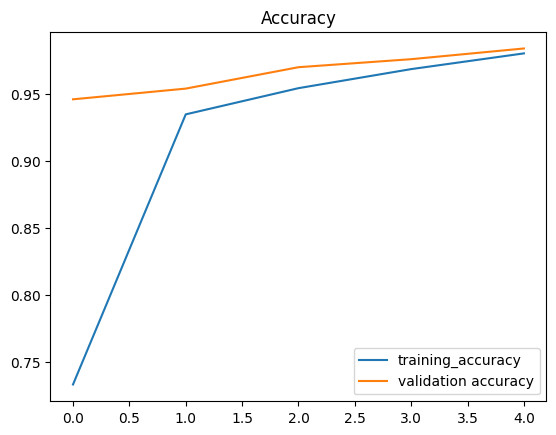

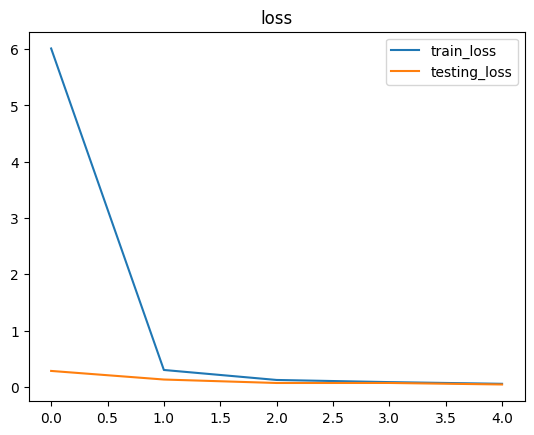

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step

W0000 00:00:1729767225.466511     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 957ms/step
Confusion Matrix
[[478   3  19]
 [  1 499   0]
 [  9   0 491]]
Classification Report
              precision    recall  f1-score   support

         aca       0.98      0.96      0.97       500
           n       0.99      1.00      1.00       500
         scc       0.96      0.98      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



W0000 00:00:1729767235.997898     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [19]:
accuracy_curve(history)
loss_curve(history)
reports(model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step


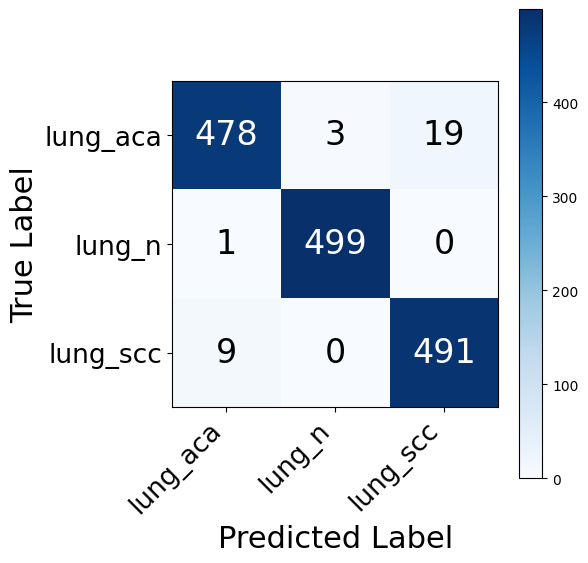

In [20]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# Knowledge Distillation

In [21]:
import os
import keras
from keras import layers
from keras import ops
import numpy as np

In [22]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.3,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

# Student Model

In [23]:
from tensorflow.keras.utils import to_categorical  # Import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
model_1_kd = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128,(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256,(3, 3), strides=(2, 2), padding="same"),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(3, activation='softmax'),
    ],
)

model_1_kd.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,931 (2.55 MB)

 Trainable params: 668,931 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
data = []
temperatures = [7,15,23,34,48,57,65,74,86,98]

Epoch 1/10


W0000 00:00:1729767293.940835     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729767340.578256     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729767365.182589     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729767378.950964     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.7301 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.7473333477973938, 0.7473333477973938]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step
Confusion Matrix
[[326 162  12]
 [  0 500   0]
 [149  56 295]]
Classification Report
              precision    recall  f1-score   support

         aca       0.69      0.65      0.67       500
           n       0.70      1.00      0.82       500
         scc       0.96      0.59      0.73       500

    accuracy                           0.75      1500
   macro avg       0.78      0.75      0.74      1500
weighted avg       0.78      0.75      0.74      1500

Epoch 1/10


W0000 00:00:1729767935.963644     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729767943.009459     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729767994.735877     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729768003.790038     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step - accuracy: 0.7673 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8606666922569275, 0.8606666922569275]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step
Confusion Matrix
[[328   2 170]
 [ 17 483   0]
 [ 20   0 480]]
Classification Report
              precision    recall  f1-score   support

         aca       0.90      0.66      0.76       500
           n       1.00      0.97      0.98       500
         scc       0.74      0.96      0.83       500

    accuracy                           0.86      1500
   macro avg       0.88      0.86      0.86      1500
weighted avg       0.88      0.86      0.86      1500

Epoch 1/10


W0000 00:00:1729768587.232446     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729768605.014654     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729768646.185879     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729768655.192866     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 516ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.8784 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.6506666541099548, 0.6506666541099548]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step
Confusion Matrix
[[493   7   0]
 [ 17 483   0]
 [500   0   0]]
Classification Report
              precision    recall  f1-score   support

         aca       0.49      0.99      0.65       500
           n       0.99      0.97      0.98       500
         scc       0.00      0.00      0.00       500

    accuracy                           0.65      1500
   macro avg       0.49      0.65      0.54      1500
weighted avg       0.49      0.65      0.54      1500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


W0000 00:00:1729769235.383826     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729769259.710990     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729769294.058612     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729769303.203938     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 484ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.2591 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.3333333432674408, 0.3333333432674408]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step
Confusion Matrix
[[  0 500   0]
 [  0 500   0]
 [  0 500   0]]
Classification Report
              precision    recall  f1-score   support

         aca       0.00      0.00      0.00       500
           n       0.33      1.00      0.50       500
         scc       0.00      0.00      0.00       500

    accuracy                           0.33      1500
   macro avg       0.11      0.33      0.17      1500
weighted avg       0.11      0.33      0.17      1500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10


W0000 00:00:1729769856.720408     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729769873.478605     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729769915.527168     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729769924.533279     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.7394 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.831333339214325, 0.831333339214325]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step
Confusion Matrix
[[319   4 177]
 [ 24 475   1]
 [ 47   0 453]]
Classification Report
              precision    recall  f1-score   support

         aca       0.82      0.64      0.72       500
           n       0.99      0.95      0.97       500
         scc       0.72      0.91      0.80       500

    accuracy                           0.83      1500
   macro avg       0.84      0.83      0.83      1500
weighted avg       0.84      0.83      0.83      1500

Epoch 1/10


W0000 00:00:1729770478.681481     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729770504.695197     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729770538.525238     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729770547.490753     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accuracy: 0.9133 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.809333324432373, 0.809333324432373]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step
Confusion Matrix
[[477   5  18]
 [ 10 490   0]
 [253   0 247]]
Classification Report
              precision    recall  f1-score   support

         aca       0.64      0.95      0.77       500
           n       0.99      0.98      0.98       500
         scc       0.93      0.49      0.65       500

    accuracy                           0.81      1500
   macro avg       0.86      0.81      0.80      1500
weighted avg       0.86      0.81      0.80      1500

Epoch 1/10


W0000 00:00:1729771100.496162     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729771126.608340     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729771159.324577     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729771168.116899     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.6307 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.7973333597183228, 0.7973333597183228]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step
Confusion Matrix
[[223   3 274]
 [ 20 478   2]
 [  5   0 495]]
Classification Report
              precision    recall  f1-score   support

         aca       0.90      0.45      0.60       500
           n       0.99      0.96      0.97       500
         scc       0.64      0.99      0.78       500

    accuracy                           0.80      1500
   macro avg       0.84      0.80      0.78      1500
weighted avg       0.84      0.80      0.78      1500

Epoch 1/10


W0000 00:00:1729771745.536447     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729771780.333591     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729771803.883014     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729771812.615335     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - accuracy: 0.9106 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8939999938011169, 0.8939999938011169]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step
Confusion Matrix
[[448   7  45]
 [  4 495   1]
 [102   0 398]]
Classification Report
              precision    recall  f1-score   support

         aca       0.81      0.90      0.85       500
           n       0.99      0.99      0.99       500
         scc       0.90      0.80      0.84       500

    accuracy                           0.89      1500
   macro avg       0.90      0.89      0.89      1500
weighted avg       0.90      0.89      0.89      1500

Epoch 1/10


W0000 00:00:1729772417.037734     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729772456.447624     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729772475.621214     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729772484.561124     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step - accuracy: 0.9218 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.887333333492279, 0.887333333492279]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step
Confusion Matrix
[[465   3  32]
 [ 11 489   0]
 [123   0 377]]
Classification Report
              precision    recall  f1-score   support

         aca       0.78      0.93      0.85       500
           n       0.99      0.98      0.99       500
         scc       0.92      0.75      0.83       500

    accuracy                           0.89      1500
   macro avg       0.90      0.89      0.89      1500
weighted avg       0.90      0.89      0.89      1500

Epoch 1/10


W0000 00:00:1729773035.733820     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729773048.606296     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729773094.237801     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/10


W0000 00:00:1729773103.223439     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 484ms/step - accuracy: 0.7702 - loss: 0.0000e+00
test_loss, test accuracy [0.0, 0.0, 0.8673333525657654, 0.8673333525657654]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 464ms/step
Confusion Matrix
[[329   3 168]
 [  9 491   0]
 [ 19   0 481]]
Classification Report
              precision    recall  f1-score   support

         aca       0.92      0.66      0.77       500
           n       0.99      0.98      0.99       500
         scc       0.74      0.96      0.84       500

    accuracy                           0.87      1500
   macro avg       0.89      0.87      0.86      1500
weighted avg       0.89      0.87      0.86      1500



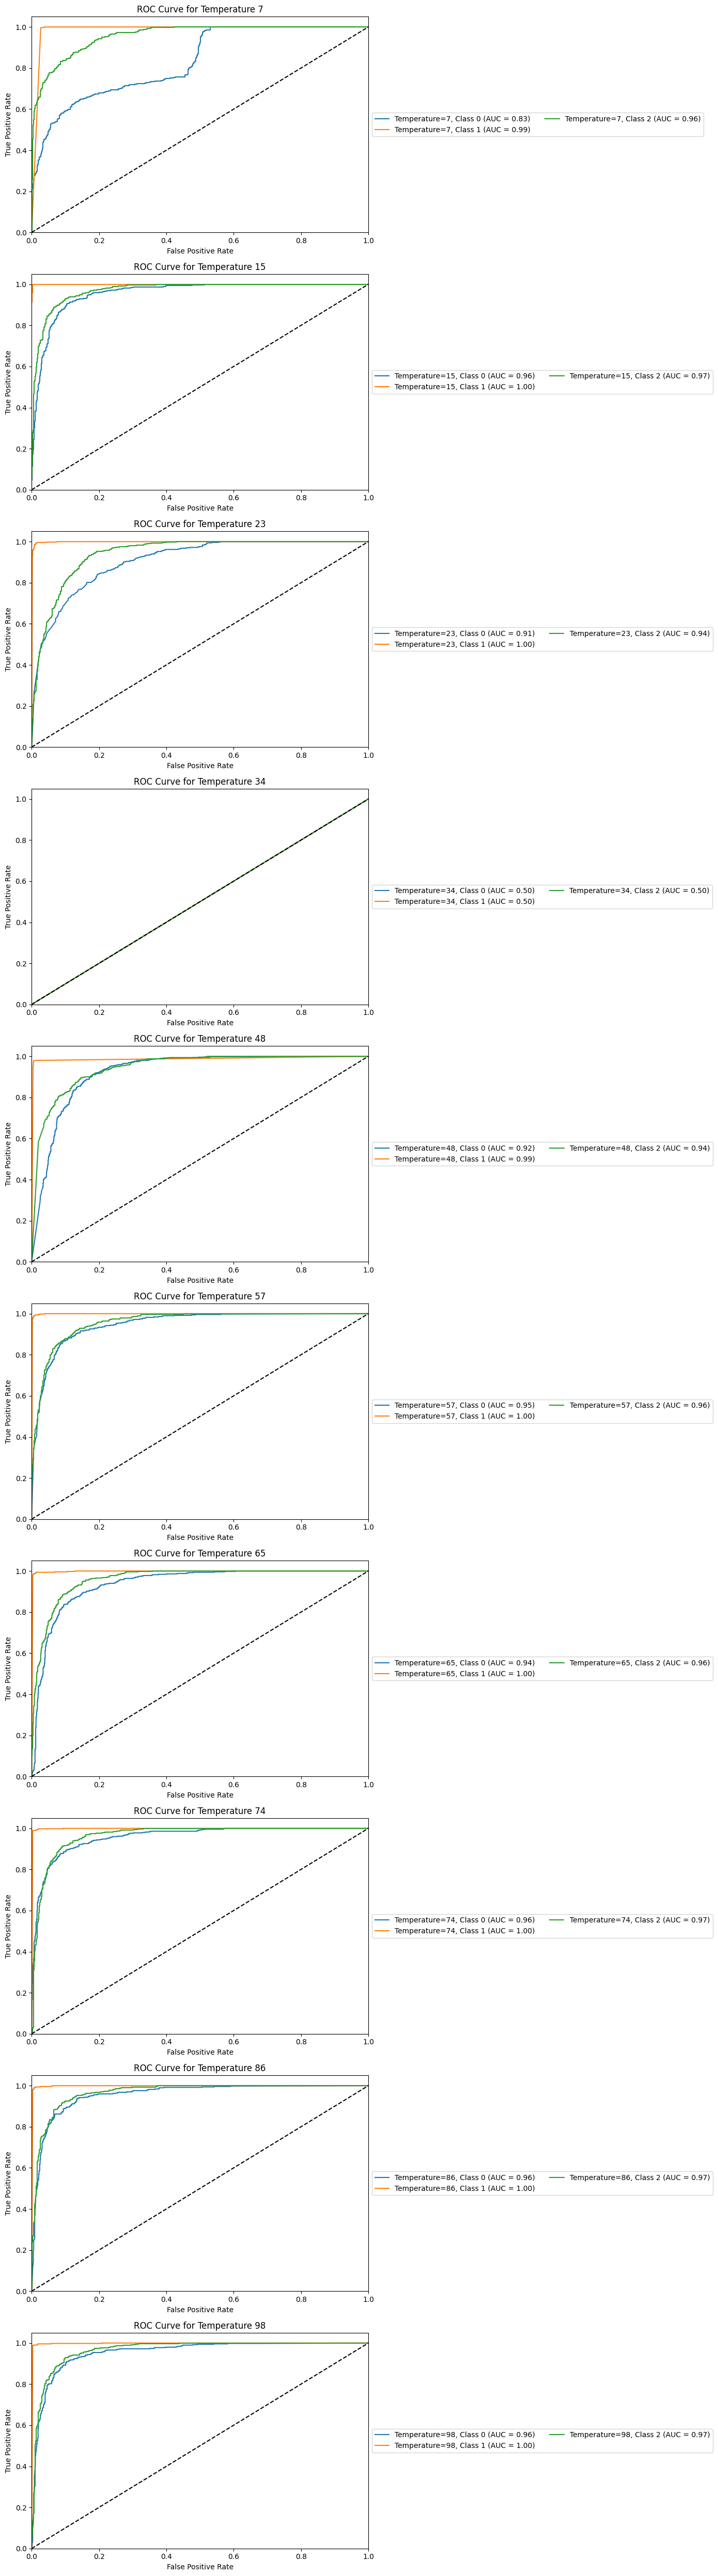

In [26]:
# Initialize a figure with subplots for each temperature
fig, axes = plt.subplots(len(temperatures), 1, figsize=(14, len(temperatures) * 5))

for idx, i in enumerate(temperatures):
    ax = axes[idx]  # Select the subplot for the current temperature

    distiller_model1 = Distiller(student=model_1_kd, teacher=model)
    distiller_model1.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy'],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.4,
        temperature=i
    )
    # Training with KD
    history_model1 = distiller_model1.fit(train_set, validation_data=validate_set, epochs=10, verbose=4)

    # Predict probabilities on the test set
    y_pred_probs = distiller_model1.predict(test_set)
    
    # Extract the true labels from the test set
    y_true = test_set.labels
    
    # Check if y_true is one-hot encoded or not
    if len(y_true.shape) == 1:  # Not one-hot encoded, single-class labels
        n_classes = np.max(y_true) + 1  # Determine number of classes
        y_true = to_categorical(y_true, num_classes=n_classes)
    else:
        n_classes = y_true.shape[1]

    # Convert probabilities to predicted classes
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_true[:, j], y_pred_probs[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])
    
    # Plot ROC curve for each class on the same subplot
    for j in range(n_classes):
        ax.plot(fpr[j], tpr[j], label=f'Temperature={i}, Class {j} (AUC = {roc_auc[j]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Temperature {i}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)  # Adjust legend position

    # Calculate accuracy, precision, recall, and F1 score
    r_accuracy = report_accracy(distiller_model1, test_set) * 100
    formatted_accuracy = f"{r_accuracy:.2f}"

    precision = precision_score(y_true_classes, y_pred_classes, average='weighted') * 100
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted') * 100
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted') * 100
    
    # Format precision, recall, and f1 score to 2 decimal places
    formatted_precision = f"{precision:.2f}"
    formatted_recall = f"{recall:.2f}"
    formatted_f1 = f"{f1:.2f}"

    # Append the data to the list
    data.append(
        {
            "Alpha": 0.4,
            "Temperature": i,
            "Accuracy": formatted_accuracy,
            "Precision": formatted_precision,
            "Recall": formatted_recall,
            "F1 Score": formatted_f1
        }
    )
    
    result = distiller_model1.evaluate(test_set, batch_size=128)
    print("test_loss, test accuracy", result)

    reports(distiller_model1, test_set)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all subplots
plt.show()

# KD Evaluation

In [27]:
results_df = pd.DataFrame(data)
results_df

,Alpha,Temperature,Accuracy,Precision,Recall,F1 Score
0,0.4,7,74.73,78.12,74.73,74.03
1,0.4,15,86.07,87.77,86.07,85.80
2,0.4,23,65.07,49.13,65.07,54.29
3,0.4,34,33.33,11.11,33.33,16.67
4,0.4,48,83.13,84.25,83.13,82.94
5,0.4,57,80.93,85.55,80.93,80.00
6,0.4,65,79.73,84.50,79.73,78.32
7,0.4,74,89.40,89.70,89.40,89.38
8,0.4,86,88.73,89.73,88.73,88.72
9,0.4,98,86.73,88.55,86.73,86.43
